 <h4> ASSIGNMENT 2</h4>
NAME: M.N.F.NIFLA <br> INDEX NO: 190413D

Question 1

In [2]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
# np . random . seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )

In [3]:
# determine a circle using 3 points (radius and center)
def circleRadius(b, c, d):
  temp = c[0]**2 + c[1]**2
  bc = (b[0]**2 + b[1]**2 - temp) / 2
  cd = (temp - d[0]**2 - d[1]**2) / 2
  det = (b[0] - c[0]) * (c[1] - d[1]) - (c[0] - d[0]) * (b[1] - c[1])
  if abs(det) < 1.0e-10:
    return None
  # Center of circle
  cx = (bc*(c[1] - d[1]) - cd*(b[1] - c[1])) / det
  cy = ((b[0] - c[0]) * cd - (c[0] - d[0]) * bc) / det
  radius = ((cx - b[0])**2 + (cy - b[1])**2)**.5
  return ((cx,cy) , radius)

In [5]:
X_new = np.concatenate((X_circ, X_line),axis=0)
candidates = [] # circles after ransac and MAE

#RANSAC
maximum_iterations = 30
for iter in range(maximum_iterations):   
  # 1.Select any 3 points
  one,two,three=np.random.choice(50),np.random.choice(50),np.random.choice(50)
  first,second,third= X_circ[one],X_circ[two],X_circ[three]
  best_circles = [] # from ransac
  # 2.Finding the circle that passes through these three points
  center , radius = circleRadius(first,second, third)
  # Define threshold distance to find inliers
  threshold_distance = 1
  # 3.Finding inliers
  inliers = []
  sq_distance = 0
  for i in range(100):
      sq_distance = (X_new[i][0] - center[0])**2 + (X_new[i][1] - center[1])**2
      sq_distance = np.sqrt(sq_distance)
      if sq_distance > radius - threshold_distance and sq_distance < radius + threshold_distance:
        inliers.append(X_new[i])
  # 4. define a threshold for inlier count to distinguish circles(best)
  inlier_threshold = 40
  if len(inliers) > inlier_threshold:
      best_circles.append([center, radius])      
      # 5. determine a new candidate circle using all the inlier points
      # Least Square Circle Fit
      x_bar = sum(inliers[i][0] for i in range(len(inliers))) /len(inliers)
      y_bar = sum(inliers[i][1] for i in range(len(inliers))) /len(inliers)

      u_i = X_circ[:,0] - x_bar
      v_i = X_circ[:,1] - y_bar
      s_u = sum(u_i)
      s_uu = sum(u_i ** 2)
      s_uuu = sum(u_i ** 3)
      s_v = sum(v_i)
      s_vv = sum(v_i ** 2)
      s_vvv = sum(v_i ** 3)
      s_uv = sum(u_i * v_i)
      s_uvv = sum(u_i * v_i * v_i)
      s_vuu = sum(v_i * u_i * u_i)
      u_c = 0.5 * ((s_uuu + s_uvv) * s_vv - (s_vvv + s_vuu) * s_uv) / (s_uu * s_vv - s_uv ** 2)
      v_c = 0.5 * ((s_uuu + s_uvv) * s_uv - (s_vvv + s_vuu) * s_uu) / (s_uv ** 2 - s_uu * s_vv)
      x_c = u_c + x_bar # center
      y_c = v_c + y_bar # center
      Radius = np.sqrt(u_c**2 + v_c**2 + (s_uu + s_vv)/len(inliers))
      # 6.Find all new inliner points and new  outlier points for new candidate circle
      new_inliers=[]
      new_outliers=[]
      for i in range(100):
        sq_distance2 = (X_new[i][0] - x_c)**2 + (X_new[i][1] - y_c)**2
        sq_distance2 = np.sqrt(sq_distance2)

        if sq_distance2 > Radius - threshold_distance and sq_distance2 < Radius + threshold_distance:
          new_inliers.append(list(X_new[i]))
        else: new_outliers.append(list(X_new[i]))
  #7.If the count of inlier points is less than threshold inlier count then skip this new candidate circle and go back to the 1st step.
  # If the count exceeds threshold inlier count then move on to next step
      if len(new_inliers) > inlier_threshold:
    # 8. Calculate the mean absolute error for the new candidate circle using the new inlier points
          MAE = sum(np.sqrt((np.array(new_inliers)[:,0]-x_c)**2 + (np.array(new_inliers)[:,1] - y_c)**2 ))
    # 9. Add this candidate circle to the shortlist along with count of inlier points and the mean absolute error
          candidates.append([(x_c,y_c), Radius, len(new_inliers), MAE, new_inliers, new_outliers, [first,second,third], [center,radius]])
    # 10. Go back to the first step and repeat for max iterations number of times
#11.When max iterations is completed, examine the shortlist of candidate circles and pick the circle with maximum inliers. 
# If more than candidate circles with same inliner count then pick the candidate circle with lesser mean absolute error

In [6]:
# get the best condidate circle with highest inliers
best = []
count = 0
for item in candidates:
    if item[2] > count:
        count = item[2]
        best.append(item)
best = best[-1]

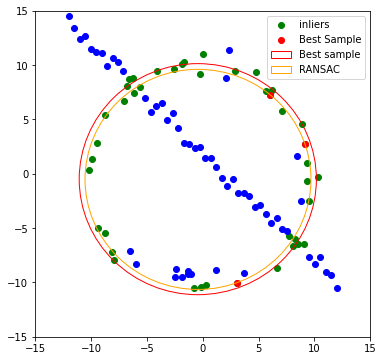

In [9]:
import matplotlib.patches as mpatches
figure, axes = plt.subplots(figsize=(6,6))
plt.axis([-15, 15, -15, 15])

plt.scatter(np.array(best[4])[:,0],np.array(best[4])[:,1],c='green',label="inliers")    #inliers
plt.scatter(np.array(best[5])[:,0],np.array(best[5])[:,1],c='blue')     #outliers
plt.scatter(np.array(best[6])[:,0],np.array(best[6])[:,1],c='red',label='Best Sample')

circ = plt.Circle(best[0], best[1],fill = False, color='red',label='Best sample')   #Best inlier circle
axes.add_artist(circ)

circ2 = plt.Circle(best[-1][0], best[-1][1], fill = False , color = 'orange',label='RANSAC')   #RANSAC circle
axes.add_artist(circ2)

axes.legend()
plt.show()


Question 2

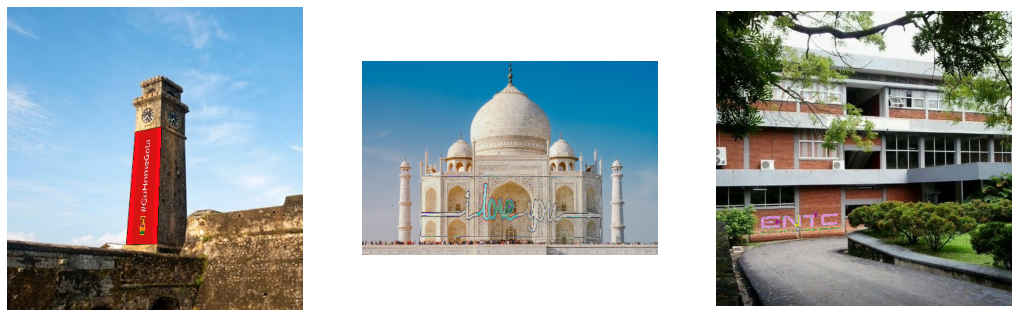

In [12]:
import cv2 as cv
def mouse_handler(event, x, y, flags, data) :
    
    if event == cv.EVENT_LBUTTONDOWN :
        cv.circle(data['im'], (x,y),3, (0,0,255), 5, 16)
        cv.imshow("Image", data['im'])
        if len(data['points']) < 4 :
            data['points'].append([x,y])

def get_four_points(im):
    # Set up data to send to mouse handler
    data = {}
    data['im'] = im.copy()
    data['points'] = []
    
    #Set the callback function for any mouse event
    cv.imshow("Image",im)
    cv.setMouseCallback("Image", mouse_handler, data)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    # Convert array to np.array
    points = np.vstack(data['points']).astype(float)
    return points

image = [('Images/Go_Home_Gota.jpg',"Images/Galle_Fort.jpg"),("Images/I_lv_u2.jpg","Images/TM.jpg"),("Images/ENTC.png","Images/Civil_Department.jpg")]
iter=0
f,ax=plt.subplots(1,3,figsize=(18,6))  
for (src, dst) in image:    
    # Read source image.
    im_src = cv.imread(src)
    cv.rotate(im_src,cv.cv2.ROTATE_90_COUNTERCLOCKWISE)
    size = im_src.shape
    # Create a vector of source points.
    pts_src = np.array([[0,0],[size[1] - 1, 0],[size[1] - 1, size[0] -1],[0, size[0] - 1 ]],dtype=float)
    # Read destination image
    im_dst = cv.imread(dst)
    # Get four corners of the billboard
    pts_dst = get_four_points(im_dst)
    # Calculate Homography between source and destination points
    h, status = cv.findHomography(pts_src, pts_dst)
    # Warp source image
    im_temp = cv.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
    # Black out polygonal area in destination image.
    if iter == 0:
        cv.fillConvexPoly(im_dst, pts_dst.astype(int), 0, 16)
    # Add warped source image to destination image.
    im_dst = im_dst + im_temp
    ax[iter].imshow(cv.cvtColor(im_dst,cv.COLOR_BGR2RGB))
    ax[iter].axis('off')
    iter += 1
plt.show()   

There are three pairs of images and here is the non-technical rationale of them :D, <br>
    1) For the country and respect the people who are fighting for #GoHomeGota<br>
    2) For my love<br>
    3) Just for fun we took over the civil department under our custedy. <br>

Question 3

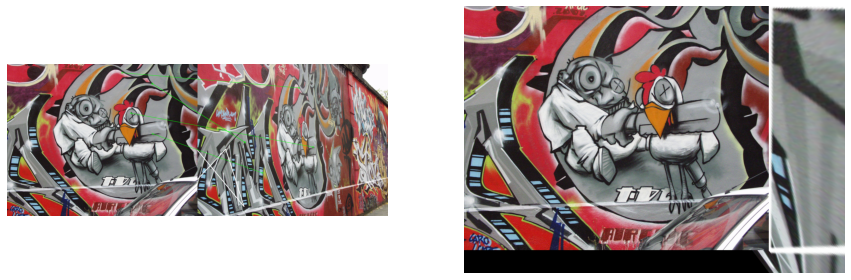

In [24]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
# Load the images in gray scale
img1 = cv.imread('Images/img1.ppm', cv.IMREAD_ANYCOLOR)
img2 = cv.imread('Images/img5.ppm', cv.IMREAD_ANYCOLOR)
# Detect the SIFT key points and compute the descriptors for the two images
sift = cv.xfeatures2d.SIFT_create()
keyPoints1, descriptors1 = sift.detectAndCompute(img1, None)
keyPoints2, descriptors2 = sift.detectAndCompute(img2, None)
# Create brute-force matcher object
bf = cv.BFMatcher()
# Match the descriptors
matches = bf.knnMatch(descriptors1, descriptors2, k=2)
# Select the good matches using the ratio test
goodMatches = []
for m, n in matches:
    if m.distance < 0.65 * n.distance:
        goodMatches.append(m)
# Apply the homography transformation if we have enough good matches
MIN_MATCH_COUNT = 10
if len(goodMatches) > MIN_MATCH_COUNT:
    # Get the good key points positions
    sourcePoints = np.float32([keyPoints1[m.queryIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([keyPoints2[m.trainIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
    # obtain the homography matrix
    M, mask = cv.findHomography(sourcePoints, destinationPoints, method=cv.RANSAC, ransacReprojThreshold=5.0)
    matchesMask = mask.ravel().tolist()
    # Apply the perspective transformation to the source image corners
    h = img1.shape[0]
    w = img1.shape[1]
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv.perspectiveTransform(corners, M)
    # Draw a polygon on the second image joining the transformed corners
    img2 = cv.polylines(img2, [np.int32(transformedCorners)], True, (255, 255, 255), 2, cv.LINE_AA)
else:
    #print("Not enough matches are found - %d/%d" % (len(goodMatches), MIN_MATCH_COUNT))
    matchesMask = None
# Draw the matches 
drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matchesMask, flags=2)
result = cv.drawMatches(img1, keyPoints1, img2, keyPoints2, goodMatches, None, **drawParameters)
# Display the results
f,ax = plt.subplots(1,2,figsize=(15,12))
ax[0].imshow(cv.cvtColor(result,cv.COLOR_BGR2RGB))
ax[0].axis('off')
im4_warped = cv.warpPerspective(img2, np.linalg.pinv(M), (1000,700))
im4_warped[0:img1.shape[0], 0:img1.shape[1]] = img1
ax[1].imshow(cv.cvtColor(im4_warped,cv.COLOR_BGR2RGB))
ax[1].axis('off')
plt.show()

GitHub link: github.com/nifla2000/EN2550-Codings.git